In [1]:

import warnings
warnings.filterwarnings("ignore")

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import kagglehub


In [2]:
dataset_path = kagglehub.dataset_download("anasmohammedtahir/covidqu")


Using Colab cache for faster access to the 'covidqu' dataset.


In [3]:

INF_DATA_ROOT = os.path.join(
    dataset_path,
    "Infection Segmentation Data",
    "Infection Segmentation Data"
)

SPLIT = "Train"
CLASS = "COVID-19"


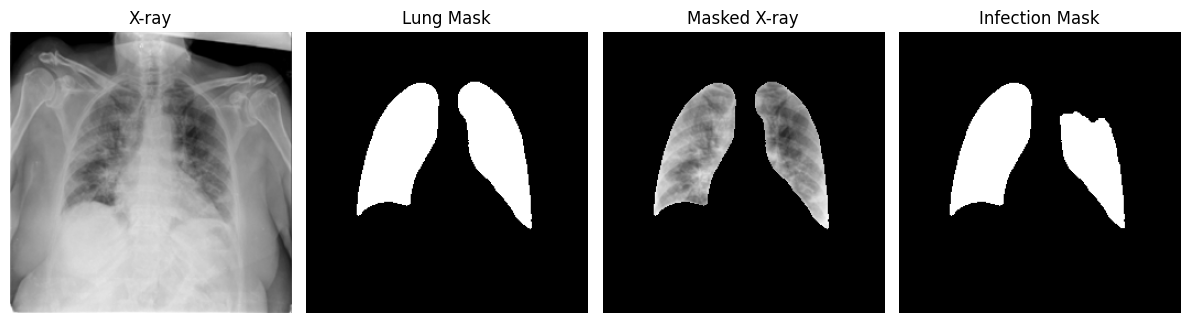

In [4]:

IMG_DIR  = os.path.join(INF_DATA_ROOT, SPLIT, CLASS, "images")
LUNG_DIR = os.path.join(INF_DATA_ROOT, SPLIT, CLASS, "lung masks")
INF_DIR  = os.path.join(INF_DATA_ROOT, SPLIT, CLASS, "infection masks")

fname = sorted(os.listdir(IMG_DIR))[0]

xray = cv2.imread(os.path.join(IMG_DIR, fname), cv2.IMREAD_GRAYSCALE)
lung = cv2.imread(os.path.join(LUNG_DIR, fname), cv2.IMREAD_GRAYSCALE)
inf  = cv2.imread(os.path.join(INF_DIR, fname), cv2.IMREAD_GRAYSCALE)

lung_bin = (lung > 0).astype(np.uint8)
masked_xray = xray * lung_bin

plt.figure(figsize=(12,4))
plt.subplot(1,4,1); plt.imshow(xray, cmap="gray"); plt.title("X-ray"); plt.axis("off")
plt.subplot(1,4,2); plt.imshow(lung_bin, cmap="gray"); plt.title("Lung Mask"); plt.axis("off")
plt.subplot(1,4,3); plt.imshow(masked_xray, cmap="gray"); plt.title("Masked X-ray"); plt.axis("off")
plt.subplot(1,4,4); plt.imshow(inf, cmap="gray"); plt.title("Infection Mask"); plt.axis("off")
plt.tight_layout()
plt.show()


In [5]:

class InfectionSegDataset(Dataset):
    def __init__(self, root, split, cls):
        self.img_dir  = os.path.join(root, split, cls, "images")
        self.lung_dir = os.path.join(root, split, cls, "lung masks")
        self.inf_dir  = os.path.join(root, split, cls, "infection masks")
        self.files = sorted(os.listdir(self.img_dir))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        fname = self.files[idx]
        xray = cv2.imread(os.path.join(self.img_dir, fname), cv2.IMREAD_GRAYSCALE)
        lung = cv2.imread(os.path.join(self.lung_dir, fname), cv2.IMREAD_GRAYSCALE)
        inf  = cv2.imread(os.path.join(self.inf_dir, fname), cv2.IMREAD_GRAYSCALE)

        lung_bin = (lung > 0).astype(np.uint8)
        x = xray * lung_bin

        x = torch.tensor(x, dtype=torch.float32).unsqueeze(0) / 255.0
        y = torch.tensor((inf > 0).astype(np.uint8), dtype=torch.float32).unsqueeze(0)

        return x, y


In [6]:

train_ds = InfectionSegDataset(INF_DATA_ROOT, SPLIT, CLASS)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True)


In [7]:

class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1), nn.ReLU()
        )
        self.pool = nn.MaxPool2d(2)
        self.mid = nn.Sequential(
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1), nn.ReLU()
        )
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)
        self.dec = nn.Sequential(
            nn.Conv2d(32, 16, 3, padding=1), nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1), nn.ReLU()
        )
        self.out = nn.Conv2d(16, 1, 1)

    def forward(self, x):
        x1 = self.enc(x)
        x2 = self.mid(self.pool(x1))
        x3 = self.dec(self.up(x2))
        return self.out(x3)


In [8]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleUNet().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(2):
    model.train()
    total_loss = 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(model(x), y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1} - Loss: {total_loss/len(train_loader):.4f}")


Epoch 1 - Loss: 0.1932
Epoch 2 - Loss: 0.1628


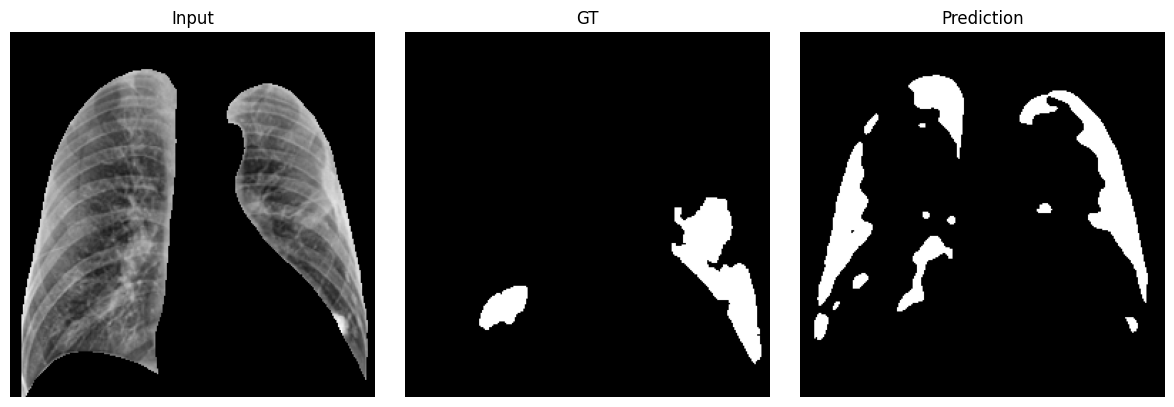

In [9]:

model.eval()
x, y = next(iter(train_loader))
x = x.to(device)

with torch.no_grad():
    pred = torch.sigmoid(model(x))

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(x[0,0].cpu(), cmap="gray"); plt.title("Input"); plt.axis("off")
plt.subplot(1,3,2); plt.imshow(y[0,0], cmap="gray"); plt.title("GT"); plt.axis("off")
plt.subplot(1,3,3); plt.imshow(pred[0,0].cpu() > 0.5, cmap="gray"); plt.title("Prediction"); plt.axis("off")
plt.tight_layout()
plt.show()
